Some initial setup for nice-looking plots:

In [1]:
%pylab inline

matplotlib.rcParams['figure.figsize'] = (8,6)
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 20

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mean']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Create image-fitting model using pyimfit

Load the pymfit package; also load astropy.io.fits so we can read FITS files:

In [2]:
import pyimfit
from astropy.io import fits

Load data image (in this case, a small cutout of an SDSS image showing a faint star), applying a correction to ensure that the data values in the resulting numpy array are little-endian and double-precision:

In [3]:
imageFile = "/Users/erwin/coding/imfit/tests/faintstar.fits"
image_faintstar = pyimfit.FixImage(fits.getdata(imageFile))

Create a ModelDescription instance based on an imfit configuration file (which specifyies a single elliptical Gaussian model):

In [4]:
configFile = "/Users/erwin/coding/imfit/tests/imfit-mcmc_reference/config_imfit_faintstar.dat"
model_desc = pyimfit.ModelDescription.load(configFile)

Create an Imfit instance containing the model, and add the image data and image-description info:

In [5]:
imfit_fitter = pyimfit.Imfit(model_desc)
imfit_fitter.loadData(image_faintstar, gain=4.72, read_noise=1.15, original_sky=124.94)

Fit the model to the data (using the default Levenberg-Marquardt solver) and extract the best-fitting parameter values
(X0, Y0, PA, ellipticity, I_0, sigma):

In [25]:
imfit_fitter.doFit()
p_bestfit = imfit_fitter.getRawParameters()

print("Best-fitting parameter values:")
for i in range(len(p_bestfit) - 1):
    print("{0:g}".format(p_bestfit[i]), end=", ")
print("{0:g}\n".format(p_bestfit[-1]))

Best-fitting parameter values:
5.64339, 6.18794, 155.354, 0.0950159, 268.919, 1.00772



## Define log-probability functions for use with emcee

Emcee requires a function to calculate the log of the posterior probability using the likelihood and the posterior probability.

We'll create a general function for the posterior probability which takes as input the current model parameters, an Imfit instance which computes the fit statistic (= $-2 \: \times$ log likelihood) and a user-supplied function for computing the prior; this will return the sum of the log likelihood and the log of the prior:

In [26]:
def lnPosterior_for_emcee( params, imfitter, lnPrior_func ):
    """
    Returns posterior probability as product of specified prior and
    likelihood computed by Imfit object using specified parameter values.
    
    Parameters
    ----------
    imfitter : Imfit instance
    
    lnPrior_func : function or other callable
        will compute log of prior
        signature = lnPrior_func(parameter_vector, Imfit_instance)
    
    Returns
    -------
    logPosterior : float
    """
    lnPrior = lnPrior_func(params, imfitter)
    if not np.isfinite(lnPrior):
        return -np.inf
    lnLikelihood = -0.5 * imfitter.computeFitStatistic(params)
    return lnPrior + lnLikelihood

Now, we'll create a prior-probability function.

For simplicity, we'll use the case of constant priors within parameter limits, with the parameter limits obtained from a user-supplied Imfit instance.

In [8]:
def lnPrior_limits( params, imfitter ):
    """
    Defines prior-probability distributions as flat within specified limits.
    If any parameter is outside the limits, we return -np.inf; otherwise, we
    return ln(1.0) = 0.
    
    Parameters
    ----------
    params : sequence of float
    
    imfitter : Imfit instance
    
    Returns
    -------
    logPrior : float
    """
    parameterLimits = imfitter.getParameterLimits()
    if None in parameterLimits:
        raise ValueError("All parameters must have lower and upper limits.")
    nParams = len(params)
    for i in range(nParams):
        if params[i] < parameterLimits[i][0] or params[i] > parameterLimits[i][1]:
            return -np.inf
    return 0.0

## Set up and run Markov-Chain Monte Carlo using emcee

Import [emcee](http://dfm.io/emcee/current/), and also [corner](https://corner.readthedocs.io/en/latest/) (so we can make a nice plot of the results):

In [9]:
import emcee
import corner

Specify the number of dimensions (= number of parameters in the model) and a large number of walkers, then instantiate
a standard emcee sampler, using our previously defined posterior function (the Imfit instance containing the data and model and the simple prior function are provided as extra arguments):

In [10]:
ndims, nwalkers = 6, 100

sampler = emcee.EnsembleSampler(nwalkers, ndims, lnPosterior_for_emcee, args=(imfit_fitter, lnPrior_limits))

Define some initial starting values -- 0.1% Gaussian perturbations around the previously determined best-fit parameters:

In [11]:
initial_pos = [p_bestfit * (1 + 0.001*np.random.randn(ndims)) for i in range(nwalkers)]

Run the sampler for 500 steps (reset it first, in case we're running this again, to ensure we start anew):

In [12]:
sampler.reset()
final_state = sampler.run_mcmc(initial_pos, 500)

Plot values from all the walkers versus step number to get an idea of where convergence might happend
(here, we just plot the ellipticity values):

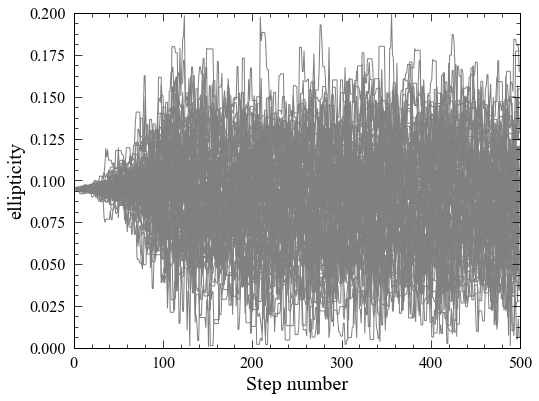

In [27]:
def PlotAllWalkers( sample_chain, parameterIndex, yAxisLabel ):
    nWalkers = sample_chain.shape[0]
    for i in range(nWalkers):
        plot(sample_chain[i,:,parameterIndex], '0.5')
    xlabel('Step number')
    ylabel(yAxisLabel)

PlotAllWalkers(sampler.chain, 3, 'ellipticity')

Define the "converged" subset of the chains as step numbers $\ge 200$, and merge all the individual walkers:

In [14]:
converged_samples = sampler.chain[:, 200:, :].reshape((-1, ndims))
print("Number of samples in \"converged\" chain = {0}".format(len(converged_samples)))

Number of samples in "converged" chain = 30000


### Corner plot of converged MCMC samples

Define some nice labels and parameter ranges for the corner plot:

In [15]:
cornerLabels = [r"$X_{0}$", r"$Y_{0}$", "PA", "ell", r"$I_{0}$", r"$\sigma$"] 

x0_range = (5.55, 5.73)
y0_range = (6.09, 6.29)
pa_range = (142,169)
ell_range = (0, 0.2)
i0_range = (240,300)
sig_range = (0.92, 1.1)
ranges = [x0_range, y0_range, pa_range, ell_range, i0_range, sig_range]

Make a corner plot; blue lines/points indicate best-fit values from above. [Note that we have to explicitly capture the Figure instance returned by corner.corner, otherwise we'll get a duplicate display of the plot]:

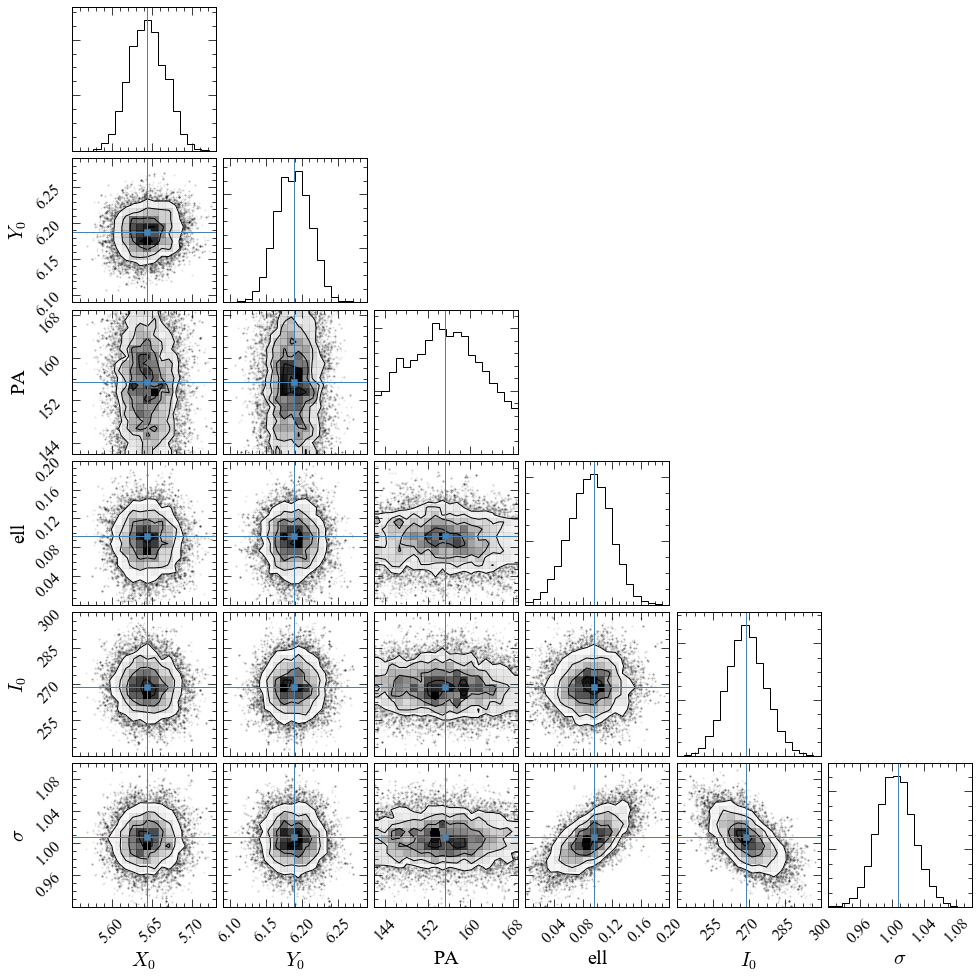

In [16]:
fig = corner.corner(converged_samples, labels=cornerLabels, range=ranges, truths=p_bestfit)